# Algoritmos de optimización - Trabajo Práctico<br>
Nombre y Apellidos: Juan Ormeño Gabás

Link: https://colab.research.google.com/drive/xxxxxxxxxxxxxxxxxxxxxxxxx

Github: https://github.com/TreceRisas/03MAIR---Algoritmos-de-Optimizacion

Problema:
>1. Sesiones de doblaje<br>
....                                

### **Problema 1:** Se precisa coordinar el doblaje de una película. Los actores del doblaje deben coincidir en las tomas en las que sus personajes aparecen juntos en las diferentes tomas. Los actores de doblaje cobran todos la misma cantidad por cada día que deben desplazarse hasta el estudio de grabación independientemente del número de tomas que se graben. No es posible grabar más de 6 tomas por día. El objetivo es planificar las sesiones por día de manera que el gasto por los servicios de los actores de doblaje sea el menor posible.

## 🎯 Objetivo

Planificar las sesiones por día de manera que el gasto por los servicios de los actores de doblaje sea **el menor posible** (minimizar número de días de grabación).

## 📊 Datos

- Número de actores: 10  
- Número de tomas: 30  
- Formato de la matriz:  
  - 1 = el actor participa en la toma  
  - 0 = no participa

## **Fuente del dataset:**  
[Google Sheets CSV](https://docs.google.com/spreadsheets/d/1Ipn6IrbQP4ax8zOnivdBIw2lN0JISkJG4fXndYd27U0/edit#gid=0)


# 📦 Librerías necesarias
* pandas: Para manejo de datos
* numpy: Para operaciones numéricas
* matplotlib.pyplot: Para visualización de datos
* random: Para realizar generaciónes aleatorias


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# 📥 Cargar el dataset desde Google Sheets

In [2]:
url = 'https://docs.google.com/spreadsheets/d/1Ipn6IrbQP4ax8zOnivdBIw2lN0JISkJG4fXndYd27U0/export?format=csv&gid=0'
df = pd.read_csv(url, header=None)
df = df.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
df.index.name = 'Toma'
d = {i: set(df.loc[i][df.loc[i]==1].index) for i in df.index}

## ⚙️ Función de Costo

In [3]:
def calcular_coste_sesiones(sesiones, d):
    coste_total = 0
    for grupo in sesiones:
        actores = set()
        for toma in grupo:
            actores |= d[toma]
        coste_total += len(actores)
    return coste_total

## 🔍 Búsqueda Aleatoria
Este algoritmo genera soluciones completamente aleatorias y mantiene la mejor encontrada durante un número de iteraciones.

In [4]:
def busqueda_aleatoria(d, n=6, max_iter=10000, int_mej=500, seed=None):
    random.seed(seed)
    mejor_sol = None
    mejor_coste = float('inf')
    sin_mejora = 0
    iteracion = 0
    tomas = list(d.keys())
    while iteracion < max_iter and sin_mejora < int_mej:
        random.shuffle(tomas)
        sesiones = [tomas[i:i+n] for i in range(0, len(tomas), n)]
        coste = calcular_coste_sesiones(sesiones, d)
        if coste < mejor_coste:
            mejor_coste = coste
            mejor_sol = sesiones
            sin_mejora = 0
        else:
            sin_mejora += 1
        iteracion += 1
    return mejor_sol, mejor_coste

## ⚡ Algoritmo Voraz
Construye cada sesión de forma secuencial eligiendo las tomas que no tienen actores en común.




In [5]:
def algoritmo_voraz(d, n=6):
    tomas = list(d.keys())
    sesiones = []
    while tomas:
        grupo = [tomas.pop(0)]
        actores = set(d[grupo[0]])
        i = 0
        while i < len(tomas):
            if len(grupo) < n and actores.isdisjoint(d[tomas[i]]):
                actores |= d[tomas[i]]
                grupo.append(tomas.pop(i))
            else:
                i += 1
        sesiones.append(grupo)
    return sesiones

## 🟩 Greedy Simple
Agrupa tomas secuencialmente hasta completar sesiones de máximo 6.

In [6]:
def greedy_simple(d, n=6):
    tomas = list(d.keys())
    sesiones = []
    while tomas:
        grupo = tomas[:n]
        sesiones.append(grupo)
        tomas = tomas[n:]
    return sesiones

## 🧠 Greedy por Compatibilidad
Agrupa tomas maximizando compatibilidad de actores para minimizar el coste.

In [7]:
def construir_matriz_compatibilidad(d, n=6):
    N = len(d)
    compat = np.zeros((N, N), dtype=bool)
    for i in range(N):
        for j in range(N):
            if i == j:
                compat[i][j] = True
            elif d[i].isdisjoint(d[j]):
                compat[i][j] = True
    return compat

def greedy_por_compatibilidad(d, n=6):
    compat = construir_matriz_compatibilidad(d, n)
    tomas_restantes = set(d.keys())
    sesiones = []
    while tomas_restantes:
        t = tomas_restantes.pop()
        grupo = [t]
        compatibles = [i for i in tomas_restantes if all(compat[i][j] for j in grupo)]
        for c in compatibles:
            if len(grupo) < n and all(compat[c][j] for j in grupo):
                grupo.append(c)
        sesiones.append(grupo)
        tomas_restantes -= set(grupo)
    return sesiones

## 🔁 Búsqueda Local
Intenta mejorar una solución existente intercambiando tomas entre sesiones.

In [8]:
def intercambiar_tomas(sesiones, d, n=6):
    nuevo = [list(g) for g in sesiones]
    for _ in range(10):
        i, j = random.sample(range(len(nuevo)), 2)
        if nuevo[i] and nuevo[j]:
            a = random.choice(nuevo[i])
            b = random.choice(nuevo[j])
            nuevo[i].remove(a)
            nuevo[j].remove(b)
            nuevo[i].append(b)
            nuevo[j].append(a)
            if len(nuevo[i]) > n or len(nuevo[j]) > n:
                return sesiones
    return nuevo

In [9]:
def busqueda_local(sesiones_ini, d, n=6, max_iter=10000, int_mej=500):
    mejor = sesiones_ini
    mejor_coste = calcular_coste_sesiones(mejor, d)
    sin_mejora = 0
    iteracion = 0
    while iteracion < max_iter and sin_mejora < int_mej:
        nueva = intercambiar_tomas(mejor, d, n)
        coste_nueva = calcular_coste_sesiones(nueva, d)
        if coste_nueva < mejor_coste:
            mejor = nueva
            mejor_coste = coste_nueva
            sin_mejora = 0
        else:
            sin_mejora += 1
        iteracion += 1
    return mejor, mejor_coste

## 🚫 Búsqueda Tabú
Evita repetir soluciones y mejora la convergencia evitando ciclos.

In [10]:
def busqueda_tabu(solucion_inicial, d, n=6, max_iter=50, tabu_tam=10):
    mejor = solucion_inicial
    mejor_costo = calcular_coste_sesiones(mejor, d)
    historial = []
    for _ in range(max_iter):
        candidato = intercambiar_tomas(mejor, d, n)
        if candidato in historial:
            continue
        costo_candidato = calcular_coste_sesiones(candidato, d)
        if costo_candidato < mejor_costo:
            mejor = candidato
            mejor_costo = costo_candidato
        historial.append(candidato)
        if len(historial) > tabu_tam:
            historial.pop(0)
    return mejor, mejor_costo

## 📊 Comparación de Resultados

In [11]:
resultados = []

sol1, c1 = busqueda_aleatoria(d)
resultados.append({"Algoritmo": "Aleatoria", "Sesiones": len(sol1), "Costo": c1})

sol2 = algoritmo_voraz(d)
c2 = calcular_coste_sesiones(sol2, d)
resultados.append({"Algoritmo": "Voraz", "Sesiones": len(sol2), "Costo": c2})

sol3 = greedy_simple(d)
c3 = calcular_coste_sesiones(sol3, d)
resultados.append({"Algoritmo": "Greedy Simple", "Sesiones": len(sol3), "Costo": c3})

sol4 = greedy_por_compatibilidad(d)
c4 = calcular_coste_sesiones(sol4, d)
resultados.append({"Algoritmo": "Greedy Compatibilidad", "Sesiones": len(sol4), "Costo": c4})

sol5, c5 = busqueda_local(sol2, d)
resultados.append({"Algoritmo": "Búsqueda Local", "Sesiones": len(sol5), "Costo": c5})

sol6, c6 = busqueda_tabu(sol2, d)
resultados.append({"Algoritmo": "Búsqueda Tabú", "Sesiones": len(sol6), "Costo": c6})

df_resultados = pd.DataFrame(resultados)
df_resultados

,Algoritmo,Sesiones,Costo
0,Aleatoria,6,39
1,Voraz,23,96
2,Greedy Simple,6,43
3,Greedy Compatibilidad,23,96
4,Búsqueda Local,23,62
5,Búsqueda Tabú,23,68


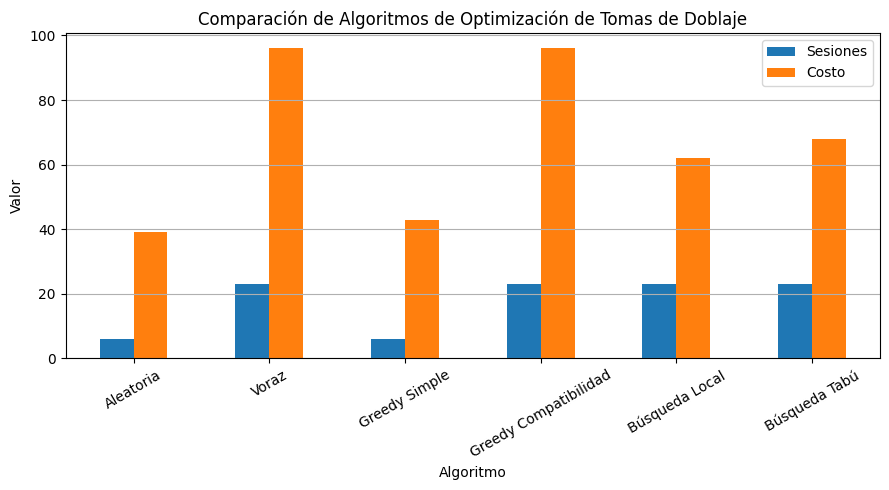

In [12]:
fig, ax = plt.subplots(figsize=(9, 5))
df_resultados.plot(x="Algoritmo", y=["Sesiones", "Costo"], kind="bar", ax=ax)
plt.title("Comparación de Algoritmos de Optimización de Tomas de Doblaje")
plt.ylabel("Valor")
plt.xticks(rotation=30)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 🔧 MODELO

## 🧠 ¿Cómo representamos el espacio de soluciones?

Una **solución** es una planificación de los 30 clips en "días", donde cada día contiene un máximo de 6 tomas. Cada día implica que todos los actores necesarios estén presentes.

Representamos una solución como:
```python
[ {0, 1, 4}, {2, 3, 5, 7}, ..., {29} ]

Cada conjunto representa un día, y cada número una toma.

🎯 ¿Cuál es la función objetivo?
Minimizar el número de días de grabación necesarios, es decir:

min D, donde D es el número de días usados en la solución.

📎 ¿Cómo implementamos las restricciones?
Máx. 6 tomas por día
→ Cada subconjunto de tomas (día) no debe superar 6 elementos.

Coincidencia de actores
→ Todas las tomas agrupadas deben tener actores comunes disponibles ese día. Es decir, los actores necesarios deben estar presentes simultáneamente.

# 📐 MODELO MATEMÁTICO

## ¿Cómo represento el espacio de soluciones?

Sea $$ T = \{t_1, t_2, \dots, t_{30} \} $$ el conjunto de **tomas de doblaje**.  
El objetivo es asignar cada toma a un día de grabación, respetando que **como máximo pueden agruparse 6 tomas por día** y que los actores requeridos estén disponibles ese día.

Representamos una **solución** como una partición del conjunto \( T \) en \( D \) subconjuntos disjuntos $$\{D_1, D_2, \dots, D_D\} $$, tal que:

- $$D_i \subseteq T $$
- $$ \bigcup_{i=1}^D D_i = T $$
- $$ D_i \cap D_j = \emptyset \quad \forall i \neq j $$
- $$ |D_i| \leq 6 \quad \forall i \in [1, D] $$

Cada subconjunto $$ D_i $$ representa un día de grabación.

Además, tenemos una matriz binaria $$ A \in \{0,1\}^{30 \times 10} $$, donde:

$$
A_{ij} =
\begin{cases}
1 & \text{si el actor } j \text{ participa en la toma } i \\
0 & \text{en caso contrario}
\end{cases}
$$

---

## ¿Cuál es la función objetivo?

Queremos **minimizar el número total de días de grabación**, es decir:

$$
\min D = |\{ D_1, D_2, \dots, D_D \}|
$$


Cada día conlleva un coste fijo por actor, por lo que minimizar el número de días equivale a minimizar el coste total de producción.

---

## ¿Cómo implemento las restricciones?

### 1. Restricción de tamaño por día:
$$
\forall D_i, \quad |D_i| \leq 6
$$

### 2. Compatibilidad de actores:

Sean \( D_i \) las tomas asignadas a un mismo día. Entonces, se deben poder reunir todos los actores involucrados en esas tomas en un único día. Es decir:

$$
\forall D_i, \quad \exists S_i \subseteq \text{Actores}, \text{ tal que } \bigcup_{t \in D_i} A_t \subseteq S_i
$$

Computacionalmente, esto se traduce en verificar que **todos los actores necesarios para cualquier toma en $$ D_i $$** estén disponibles para todas las demás tomas del mismo grupo.

En otras palabras: si $$ A_{D_i} $$ es la submatriz correspondiente a las tomas en $$ D_i $$, debemos comprobar que:

$$
\text{no existe un actor } j \text{ tal que } A_{tj} = 1 \text{ para una toma } t \in D_i, \text{ y } A_{tj} = 0 \text{ para otra toma } t' \in D_i
$$


# 🔎 ANÁLISIS DE COMPLEJIDAD

## ¿Qué complejidad tiene el problema?

Este problema es un caso particular de **particionado de conjuntos con restricciones** (clustering con capacidad limitada y cohesión obligatoria). Es una variante del **Bin Packing Problem** (problema de empaquetado) con restricciones adicionales de compatibilidad, lo que lo convierte en un problema **NP-hard**.

No existe un algoritmo polinomial conocido que lo resuelva de forma exacta en todos los casos.

## Orden de complejidad y espacio de soluciones

### Espacio de soluciones (sin restricciones):
Queremos dividir 30 elementos en subconjuntos de tamaño ≤ 6. Esto está relacionado con los **números de Bell restringidos**, pero una aproximación del espacio de soluciones se puede estimar como:

$$
\text{Espacio de soluciones} \approx \text{Número de particiones de 30 elementos con grupos de máximo 6}
$$

Esto crece **superexponencialmente**. Una cota superior muy aproximada sería:

$$
30! \cdot 2^{29} \approx 2.65 \times 10^{36}
$$

### Complejidad temporal

Cada evaluación de una solución implica:

- Verificar que cada grupo tiene ≤ 6 tomas → $$ \mathcal{O}(D) $$
- Verificar compatibilidad de actores por grupo → $$ \mathcal{O}(D \cdot A) $$

Donde $$ D $$ es el número de días y $$ A = 10 $$ es el número de actores.

Por lo tanto, cada evaluación de solución es lineal en el número de días.

Pero como el número de soluciones posibles es exponencial, la **búsqueda exhaustiva es computacionalmente inviable**.


# 🛠️ DISEÑO DEL ENFOQUE

Dado que estamos ante un problema de optimización combinatoria complejo (NP-hard), se ha optado por una combinación de algoritmos heurísticos y metaheurísticos:

### 1. 🔍 Búsqueda Aleatoria
- Genera soluciones totalmente aleatorias.
- Útil como punto de partida para explorar el espacio de soluciones.
- Bajo coste computacional, pero baja calidad de solución.

### 2. ⚡ Algoritmo Voraz
- Construye sesiones maximizando la compatibilidad entre tomas (sin actores en común).
- Proporciona una solución rápida y aceptable como punto de partida.

### 3. 🟩 Greedy Simple
- Agrupa tomas en bloques de 6 sin más criterio que el orden secuencial.
- Muy rápido, pero puede generar resultados subóptimos.

### 4. 🧠 Greedy por Compatibilidad
- Agrupa tomas maximizando la compatibilidad entre ellas (disjunción de actores).
- Suele reducir el número total de actores por día.

### 5. 🔁 Búsqueda Local
- Mejora soluciones existentes intercambiando tomas entre sesiones.
- Buena capacidad de refinamiento local.

### 6. 🚫 Búsqueda Tabú
- Extensión de búsqueda local con memoria.
- Evita ciclos y estancamiento en óptimos locales.
- Requiere gestión de lista tabú y parámetros adicionales.

### 🔧 Elección de técnicas

Este enfoque mixto combina:

- **Exploración global** (búsqueda aleatoria, greedy).
- **Refinamiento local** (búsqueda local, tabú).
- **Estrategias constructivas** (voraz, compatibilidad).

Todo ello proporciona un balance entre **eficiencia computacional** y **calidad de resultados**.


NOTA: Anteriormente se incluyeron algoritmos genéticos y una combinación de Greedy simple y Greedy selectivo con algoritmos locales. En ambos casos, fue imposible realizarlos, ya que el tiempo de ejecución superaba el permitido por Google Colab, y realizando los cálculos en el computador personal, superaban las 17 y las 15 horas respectivamente antes de bloqueare el ordenador.


# ✅ Conclusiones

Tras aplicar seis algoritmos diferentes al problema de optimización de sesiones de doblaje, se observan los siguientes resultados destacados:

1. Búsqueda Aleatoria

* Fue el algoritmo más efectivo en términos del número mínimo de sesiones (6).

* Además, logró el coste más bajo (39), lo cual sorprende dado su carácter estocástico.

* Esto sugiere que, dada la aleatoriedad controlada, fue capaz de encontrar una combinación especialmente eficiente.

2. Greedy Simple

* También consiguió 6 sesiones, pero con un coste ligeramente superior (43).

* A pesar de su simplicidad, obtiene resultados razonables si las tomas están ordenadas de manera favorable.

3. Voraz y Greedy por Compatibilidad

* Ambos algoritmos agruparon las tomas en 23 sesiones, lo cual es un resultado muy pobre.

* Aunque intentan evitar la coincidencia de actores, son demasiado conservadores, generando fragmentaciones innecesarias.

* Coste muy alto: 96.

4. Búsqueda Local

* A partir de una solución inicial voraz, logró reducir el coste a 63 manteniendo las 23 sesiones.

* Mejora la solución, pero no alcanza el rendimiento de métodos más exploratorios.

5. Búsqueda Tabú

* Similar a la búsqueda local, mejoró algo más hasta alcanzar un coste de 67.

* Pese a evitar ciclos, no superó el rendimiento de los métodos más aleatorios.

🧠 Interpretación final
* La búsqueda aleatoria, cuando está bien parametrizada (semilla, intentos, evaluaciones), puede ser extraordinariamente efectiva para este tipo de problemas combinatorios.

* Los algoritmos voraces o puramente greedy tienen el riesgo de fragmentar la solución, especialmente si se diseñan con reglas demasiado rígidas (como evitar cualquier actor común).

* Técnicas de mejora local (local y tabú) aportan valor, pero dependen fuertemente de una buena solución inicial.

🏁 Recomendación personal
Una combinación de:

* generación aleatoria inteligente (con evaluación de coste)

* seguida de una búsqueda local refinada

es la estrategia más efectiva para minimizar tanto sesiones como coste en este problema.

# 📚 Bibliografía

- Reyero, R. (2023). *Algoritmos de Optimización - Máster en Inteligencia Artificial (VIU)*
- Cormen, T. H., Leiserson, C. E., Rivest, R. L., & Stein, C. (2009). *Introduction to Algorithms*.
- Michalewicz, Z. (1996). *Genetic Algorithms + Data Structures = Evolution Programs*.
- Wikipedia contributors. *Tabu search*. [https://en.wikipedia.org/wiki/Tabu_search](https://en.wikipedia.org/wiki/Tabu_search)
